# Modelo de predicción de incumplimiento – Redes neuronales artificiales.

En este código se tratara sobre la adaptación de datos si es necesario de la base de datos depurada,  la creación de distintos modelos probabilisticos, optimización del modelo que mejor funciono en su prototipo, se utilizara principalmente la librería tensorFlow de Python para la creación y entrenamiento de la red neuronal.

## Análisis de datos

Exploraremos los datos para asegurarnos que estén en el formato correcto para ser utilizados y que no tienen valores nulos que afecten al modelo.

In [21]:
import pandas as pd
df = pd.read_csv("Base_datos_Entrenamiento.csv")
print(df.head())

        id  loan_amnt        term  int_rate  installment grade sub_grade  \
0  1077501     5000.0   36 months     10.65       162.87     B        B2   
1  1076863    10000.0   36 months     13.49       339.31     C        C1   
2  1075358     3000.0   60 months     12.69        67.79     B        B5   
3  1075269     5000.0   36 months      7.90       156.46     A        A4   
4  1069639     7000.0   60 months     15.96       170.08     C        C5   

  home_ownership  annual_inc verification_status  ... delinq_2yrs  \
0           RENT     24000.0            Verified  ...         0.0   
1           RENT     49200.0     Source Verified  ...         0.0   
2           RENT     80000.0     Source Verified  ...         0.0   
3           RENT     36000.0     Source Verified  ...         0.0   
4           RENT     47004.0        Not Verified  ...         0.0   

  earliest_cr_line  inq_last_6mths  open_acc pub_rec  revol_bal  revol_util  \
0         Jan-1985             1.0       3.0     

In [22]:
# Identificar valores nulos
print("\nValores nulos por columna:\n")
print(df.isnull().sum().sort_values(ascending=False))


Valores nulos por columna:

id                            0
dti                           0
collections_12_mths_ex_med    0
total_acc                     0
revol_util                    0
revol_bal                     0
pub_rec                       0
open_acc                      0
inq_last_6mths                0
earliest_cr_line              0
delinq_2yrs                   0
purpose                       0
loan_amnt                     0
loan_status                   0
verification_status           0
annual_inc                    0
home_ownership                0
sub_grade                     0
grade                         0
installment                   0
int_rate                      0
term                          0
acc_now_delinq                0
dtype: int64


No existen valores nulos, pero hay varias variables que estan desbalanceadas, sera necesario balancear las variables para poder utilizarlas sin generar problemas en la predicción.

In [23]:
lista=["loan_status"]
for col in lista:
    print(f"Valores únicos en {col}:")
    print(df[col].unique())
    print()

Valores únicos en loan_status:
['Fully Paid' 'Current' 'Charged Off' 'Default' 'Late (31-120 days)'
 'In Grace Period' 'Late (16-30 days)'
 'Does not meet the credit policy. Status:Fully Paid'
 'Does not meet the credit policy. Status:Charged Off' 'Issued']



En este caso se busca simplificar la variable home_ownership ya que tiene muchos valores con un gran desbalance, con la unión de variables poco representativas, sera mejor disminuir la cantidad de valores para que solo tengan valores representativos

In [24]:
df = df[~df['home_ownership'].isin(['OTHER', 'NONE', 'ANY'])]
purpose_columns = [
    "moving",
    "vacation",
    "house",
    "educational",
    "renewable_energy",
    "wedding",
    "medical",
    "car",
    "small_business",
    "major_purchase",
    "other"
]

df.loc[df["purpose"].isin(purpose_columns), "purpose"] = "other"

Ahora es necesario realizar el mismo proceso para la variable principal, ya que loan_status sufre de un desbalanceo fuerte, simplificaremos las clases que describen el estado de pago o no de la deuda, y aunque estas clases se les da importancia por no cumplir las reglas del banco el cual recaudo los datos, no sabemos ni su situación y tampoco es representativo para el uso que buscamos darle, ya que solo importa el pago o impago y su probabilidad.

In [25]:
purpose_columns = ["Does not meet the credit policy. Status:Fully Paid","Fully Paid"]
df.loc[df["loan_status"].isin(purpose_columns), "loan_status"] = "Fully Paid"

purpose_columns = ["Does not meet the credit policy. Status:Charged Off","Charged Off"]
df.loc[df["loan_status"].isin(purpose_columns), "loan_status"] = "Charged Off"

Se eliminarán las clases issued y default ya que no dan información destinada al objetivo del modelo probabilistico, ya que no predice el pago o impago, será mejor su eliminación.

In [26]:
columna = 'loan_status'  # Reemplaza con el nombre de la columna
valor = 'Issued'  # Reemplaza con el valor que deseas eliminar

df = df[df[columna] != valor]

In [27]:
columna = 'loan_status'  # Reemplaza con el nombre de la columna
valor = 'Default'  # Reemplaza con el valor que deseas eliminar

df = df[df[columna] != valor]

Esta grafica muestra los cambios realizados, y como se puede notar aún existen desbalances claros, en este caso se ha decidido aplicar una simplificación binaria ya que el objetivo es predecir el incumplimiento, no es necesario mantener el resto de las variables, y mantenerlas solo harán más difícil el balanceo, el cual es necesario para tener una red neuronal no sesgada.

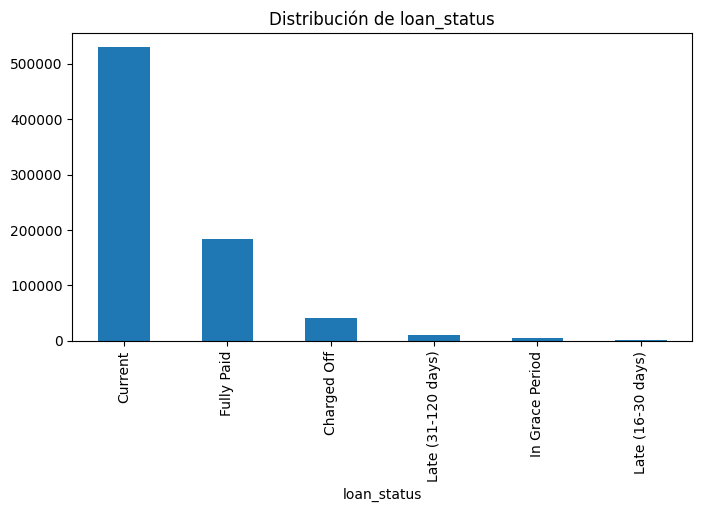

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# ...existing code...
lista=["loan_status"]
for col in lista:
    plt.figure(figsize=(8,4))
    if df[col].dtype == "object":
        df[col].value_counts().plot(kind='bar')
    else:
        sns.histplot(data=df, x=col, kde=True)
    plt.title(f"Distribución de {col}")
    plt.show()

In [28]:
df['target'] = df['loan_status'].apply(lambda x: 1 if x in ['Charged Off', 'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)'] else 0)

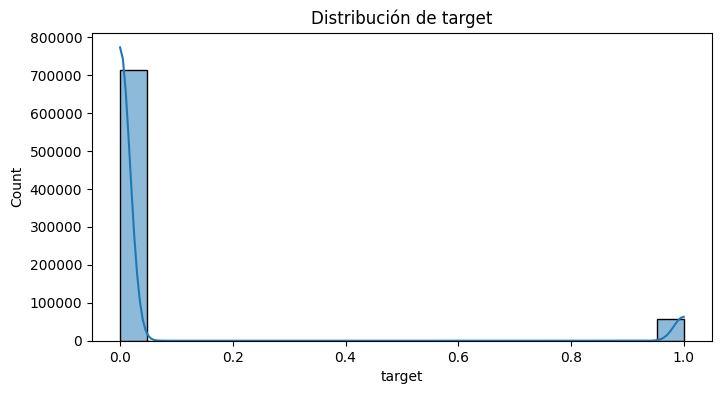

In [13]:
lista=["target"]
for col in lista:
    plt.figure(figsize=(8,4))
    if df[col].dtype == "object":
        df[col].value_counts().plot(kind='bar')
    else:
        sns.histplot(data=df, x=col, kde=True)
    plt.title(f"Distribución de {col}")
    plt.show()

Notando la clasificación 0 muestra de que es probable que el cliente mantenga su pago, y uno muestra la posibilidad del impago de la deuda, el desbalance es muy grande, pero combinando distintas estrategias podremos tener un modelo sin tanto sesgo, y la ventaja es que ante menos clases será más fácil aplicar las distintas estrategias de balance

Ahora nos dedicaremos a preparar los datos para el entrenamiento, se aplicará la separación de la variable earliest_cr_line, para poder transformarlo a un formato compatible con redes neuronales, la segunda aplicar codificación para las variables compuestas de string, para la mayoria one-hot, y codificación cardinal para las variables que tienen orden como term.

# Preparación datos para entrenamiento para ser utilizado en el modelo probabilistico

In [29]:
dEntrenamiento= df.copy()

In [30]:
#eliminar variables no utiles para entrenar el modelo
dEntrenamiento.drop(["id","loan_status"], axis=1, inplace=True)

In [31]:
print(dEntrenamiento["earliest_cr_line"])

0         Jan-1985
1         Feb-1996
2         Jan-1996
3         Nov-2004
4         Jul-2005
            ...   
779989    Sep-2004
779990    Mar-1974
779991    Sep-2003
779992    Oct-2003
779993    Dec-2001
Name: earliest_cr_line, Length: 771611, dtype: object


Es necesario cambiar el formato de esta variable, ya que las neuronas no aceptan string directamente, pero tampoco aceptan el formato dataframe, se ha decidido separa los años y meses en dos columnas distintas, se probaran las variables que más impacto generan, asi tambien podremos comprobar si el rendimiento de esta transformación  para la búsqueda de patrones es notable o no. 

In [32]:
import pandas as pd

# Convert 'earliest_cr_line' to datetime
dEntrenamiento['earliest_cr_line'] = pd.to_datetime(dEntrenamiento['earliest_cr_line'], format='%b-%Y')

# Extract year and month
dEntrenamiento['earliest_cr_year'] = dEntrenamiento['earliest_cr_line'].dt.year
dEntrenamiento['earliest_cr_month'] = dEntrenamiento['earliest_cr_line'].dt.month

# Optionally, drop the original column
dEntrenamiento.drop('earliest_cr_line', axis=1, inplace=True)

In [33]:
dEntrenamiento.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,home_ownership,annual_inc,verification_status,purpose,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,acc_now_delinq,target,earliest_cr_year,earliest_cr_month
0,5000.0,36 months,10.65,162.87,B,B2,RENT,24000.0,Verified,credit_card,...,3.0,0.0,13648.0,83.7,9.0,0.0,0.0,0,1985,1
1,10000.0,36 months,13.49,339.31,C,C1,RENT,49200.0,Source Verified,other,...,10.0,0.0,5598.0,21.0,37.0,0.0,0.0,0,1996,2
2,3000.0,60 months,12.69,67.79,B,B5,RENT,80000.0,Source Verified,other,...,15.0,0.0,27783.0,53.9,38.0,0.0,0.0,0,1996,1
3,5000.0,36 months,7.90,156.46,A,A4,RENT,36000.0,Source Verified,other,...,9.0,0.0,7963.0,28.3,12.0,0.0,0.0,0,2004,11
4,7000.0,60 months,15.96,170.08,C,C5,RENT,47004.0,Not Verified,debt_consolidation,...,7.0,0.0,17726.0,85.6,11.0,0.0,0.0,0,2005,7


El resto de variables que son string se transformaran en booleanos utilizando one-hot, esto separa cada valor único en una columna que muestra su existencia, asi para una serie de valores se convierten en columnas en las cuales solo una puede ser true.

In [34]:
# Identificar columnas de tipo string
string_columns = dEntrenamiento.select_dtypes(include=['object']).columns.tolist()

# Aplicar one-hot encoding y eliminar las columnas originales
dEntrenamiento= pd.get_dummies(dEntrenamiento, columns=string_columns, drop_first=False)

In [35]:
print(dEntrenamiento.info())

<class 'pandas.core.frame.DataFrame'>
Index: 771611 entries, 0 to 779993
Data columns (total 71 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   loan_amnt                            771611 non-null  float64
 1   int_rate                             771611 non-null  float64
 2   installment                          771611 non-null  float64
 3   annual_inc                           771611 non-null  float64
 4   dti                                  771611 non-null  float64
 5   delinq_2yrs                          771611 non-null  float64
 6   inq_last_6mths                       771611 non-null  float64
 7   open_acc                             771611 non-null  float64
 8   pub_rec                              771611 non-null  float64
 9   revol_bal                            771611 non-null  float64
 10  revol_util                           771611 non-null  float64
 11  total_acc         

Se utilizará para balancear dos técnicas, la primera es eliminar elementos de la clase mayoritaria, esto permitirá que la clase minoritaria tenga mayor peso en el entrenamiento, la técnica especifica es tomek link, para separar mejor las clases, y para permitir tener una mayor representación se usa smote para aumentar la cantidad de muestras para la clase minoritaria.

In [ ]:
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE

# Separar características y target
X = dEntrenamiento.drop('target', axis=1)
y = dEntrenamiento['target']

# Submuestreo utilizando TomekLinks para eliminar muestras cercanas
tl = TomekLinks()
X_under, y_under = tl.fit_resample(X, y)

# Sobremuestreo de la clase minoritaria hasta el 30% de la clase mayoritaria
smote = SMOTE(sampling_strategy=0.3, random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_under, y_under)

# Combinar las características balanceadas con el target
dEntrenamiento_balanced = pd.concat([pd.DataFrame(X_balanced, columns=X.columns), pd.Series(y_balanced, name='target')], axis=1)

# Verificar la distribución de clases después del balanceo
print("Distribución de clases después del balanceo:")
print(y_balanced.value_counts())

In [1]:
# codigo para usar los datos procesados anteriormente
import pandas as pd
dEntrenamiento = pd.read_csv("Datos_Entrenamiento.csv")
dEntrenamiento_balanced= pd.read_csv("Datos_Entrenamiento_Balanceados.csv")

Aunque se pueda igualar las clases en este caso no es recomendable, la clase minoritaria originalmente tenía una representación muy baja, será mejor utilizar pesos en el modelo para que la red neuronal tenga más en cuenta la clase minoritaria, asi no será necesario eliminar mucha información de la clase mayoritaria ni tampoco tener mucha información repetida por parte de la clase minoritaria.

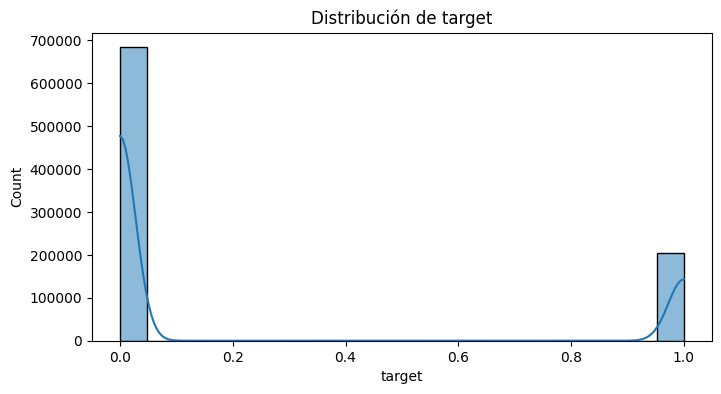

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
lista=["target"]
for col in lista:
    plt.figure(figsize=(8,4))
    if dEntrenamiento_balanced[col].dtype == "object":
        dEntrenamiento_balanced[col].value_counts().plot(kind='bar')
    else:
        sns.histplot(data=dEntrenamiento_balanced, x=col, kde=True)
    plt.title(f"Distribución de {col}")
    plt.show()

# Entrenamiento y optimización de la red neuronal

Para mejorar el modelo se ha decido aplicar varias estrategias, la primera es normalizar los datos, asi puede aumentar la precisión del modelo, tambien se ha añadido el peso de las clases, asi la red neuronal puede darle mayor importancia y evite que la representación menor de la clase minoritaria afecte el cómo decide las clases.

La red neuronal se compone de dos capas de 32 y 16 neuronas con activación relu con la capa de salida de una neurona con una activación sigmoide, la compilación del modelo está compuesta por el optimizador Adaptive Moment Estimation, la función de perdida es binary_crossentropy, útil en este caso por ser una clasificación binaria, y las métricas de optimización se decidió por el ROC siglas de área bajo la curva, PR Calcula el área bajo la curva de precisión-recall, útil en problemas con clases desbalanceadas.


In [2]:
from sklearn.utils import class_weight
import numpy as np
# Definir y compilar el modelo
from tensorflow import keras
from tensorflow.keras import layers


# Supongamos que dEntrenamiento_balanced contiene todas las columnas
X = dEntrenamiento_balanced.drop("target", axis=1)
y = dEntrenamiento_balanced["target"]

# Normalización opcional
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# División de datos
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Calcular pesos de clase para manejar la clase minoritaria
classes = np.unique(y_train)
weights = class_weight.compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))


model = keras.Sequential([
    layers.Dense(32, activation="relu", input_shape=(X_scaled.shape[1],)),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[keras.metrics.AUC(name="auc", curve="ROC"),keras.metrics.AUC(name="pr_auc", curve="PR")])
y_train = y_train.reset_index(drop=True)
X_train = pd.DataFrame(X_train).reset_index(drop=True)

model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=1, class_weight=class_weights)

2025-01-30 17:25:00.679938: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-30 17:25:00.909645: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-30 17:25:00.972550: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-30 17:25:01.338596: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-30 17:25:03.977406: W tensorflow/compiler/tf2

Epoch 1/30


I0000 00:00:1738275925.640542    1803 service.cc:146] XLA service 0x7f9734004b10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738275925.640609    1803 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1050, Compute Capability 6.1
2025-01-30 17:25:25.768079: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-30 17:25:26.198820: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


   33/22224 ━━━━━━━━━━━━━━━━━━━━ 1:49 5ms/step - auc: 0.4570 - loss: 0.7917 - pr_auc: 0.2070

I0000 00:00:1738275928.014746    1803 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


22224/22224 ━━━━━━━━━━━━━━━━━━━━ 143s 6ms/step - auc: 0.9036 - loss: 0.3384 - pr_auc: 0.8562
Epoch 2/30
22224/22224 ━━━━━━━━━━━━━━━━━━━━ 140s 6ms/step - auc: 0.9228 - loss: 0.3031 - pr_auc: 0.8806
Epoch 3/30
22224/22224 ━━━━━━━━━━━━━━━━━━━━ 134s 6ms/step - auc: 0.9260 - loss: 0.2989 - pr_auc: 0.8840
Epoch 4/30
22224/22224 ━━━━━━━━━━━━━━━━━━━━ 78s 3ms/step - auc: 0.9267 - loss: 0.2979 - pr_auc: 0.8852
Epoch 5/30
22224/22224 ━━━━━━━━━━━━━━━━━━━━ 87s 4ms/step - auc: 0.9274 - loss: 0.2970 - pr_auc: 0.8853
Epoch 6/30
22224/22224 ━━━━━━━━━━━━━━━━━━━━ 101s 5ms/step - auc: 0.9277 - loss: 0.2973 - pr_auc: 0.8855
Epoch 7/30
22224/22224 ━━━━━━━━━━━━━━━━━━━━ 84s 4ms/step - auc: 0.9275 - loss: 0.2968 - pr_auc: 0.8854
Epoch 8/30
22224/22224 ━━━━━━━━━━━━━━━━━━━━ 96s 4ms/step - auc: 0.9285 - loss: 0.2955 - pr_auc: 0.8863
Epoch 9/30
22224/22224 ━━━━━━━━━━━━━━━━━━━━ 77s 3ms/step - auc: 0.9281 - loss: 0.2965 - pr_auc: 0.8856
Epoch 10/30
22224/22224 ━━━━━━━━━━━━━━━━━━━━ 80s 4ms/step - auc: 0.9289 - loss: 

In [3]:

from sklearn.metrics import f1_score, precision_score, recall_score,accuracy_score


y_pred_probs = model.predict(X_test)
y_pred_classes = (y_pred_probs >= 0.5).astype(int)  # Ajustar umbral
acc = accuracy_score(y_test, y_pred_classes)
prec = precision_score(y_test, y_pred_classes)
rec = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
print(acc, prec, rec, f1)

5556/5556 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
0.9173496076721883 0.8684512964260687 0.7559719883854281 0.8083174619739623


# Metricas datos de testeo

Exactitud 0.9173496076721883

Presición 0.8684512964260687

Recall 0.7559719883854281 

F1 score 0.8083174619739623

In [4]:
X = dEntrenamiento.drop("target", axis=1)
y = dEntrenamiento["target"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_pred_probs = model.predict(X_scaled)
y_pred_classes = (y_pred_probs >= 0.5).astype(int)  # Ajustar umbral
acc = accuracy_score(y, y_pred_classes)
prec = precision_score(y, y_pred_classes)
rec = recall_score(y, y_pred_classes)
f1 = f1_score(y, y_pred_classes)
print(acc, prec, rec, f1)

24113/24113 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step
0.6189906572093969 0.11081669691470054 0.5779510213915707 0.1859745207762829


# Metricas datos de entrenamiento

Exactitud 0.6189906572093969

Presición 0.11081669691470054

Recall 0.5779510213915707

F1 score 0.1859745207762829   

In [5]:
# Datos de entrada
X = dEntrenamiento_balanced.drop("target", axis=1)
y = dEntrenamiento_balanced["target"]


X_scaled = scaler.transform(X)
y_pred_probs = model.predict(X_scaled)
y_pred_classes = (y_pred_probs >= 0.5).astype(int)  # Ajustar umbral
acc = accuracy_score(y, y_pred_classes)
prec = precision_score(y, y_pred_classes)
rec = recall_score(y, y_pred_classes)
f1 = f1_score(y, y_pred_classes)
print(acc, prec, rec, f1)

27779/27779 ━━━━━━━━━━━━━━━━━━━━ 47s 2ms/step
0.6830467880795075 0.41242955935303194 0.8794507058731769 0.5615248980252459


# Metricas datos de entrenamiento balanceado

Exactitud 0.6189906572093969

Presición 0.11081669691470054

Recall 0.5779510213915707

F1 score 0.1859745207762829 

## Optimización de Redes neuronales

Resumen de la Optimización Realizada
Objetivo de la Optimización:
Optimizar la arquitectura y los hiperparámetros de una red neuronal para maximizar la precisión (accuracy) en la clasificación de estados de préstamos, manejando al mismo tiempo posibles desbalances en las clases.
Hiperparámetros Probados:
1.	Número de Capas Ocultas (num_layers):
o	Valores Probados: 1, 2, 3
o	Descripción: Determina la profundidad de la red neuronal.
2.	Unidades por Capa Oculta (units_0, units_1, units_2):
o	Valores Probados por Capa: 16, 32, 48, ..., 128
o	Descripción: Número de neuronas en cada capa oculta, afectando la capacidad del modelo para aprender patrones complejos.
3.	Regularización L2 (l2_0, l2_1, l2_2):
o	Valores Probados: Entre 0.0001 y 0.01 (muestreados logarítmicamente)
o	Descripción: Previene el sobreajuste penalizando los pesos grandes en las capas ocultas.
4.	Tasa de Dropout (dropout_0, dropout_1, dropout_2):
o	Valores Probados: 0.1, 0.2, 0.3, 0.4, 0.5
o	Descripción: Proporción de neuronas que se desactivan durante el entrenamiento para mejorar la generalización.
5.	Tasa de Aprendizaje (learning_rate):
o	Valores Probados: 0.001, 0.0005, 0.0001
o	Descripción: Velocidad a la que el modelo actualiza sus pesos, influyendo en la convergencia y estabilidad del entrenamiento.
Proceso de Evaluación:
•	Métrica Objetivo: val_accuracy para maximizar la precisión en el conjunto de validación.
•	Estrategia de Entorno de Evaluación: Uso de EarlyStopping para detener el entrenamiento si no hay mejora en la pérdida de validación durante 4 épocas consecutivas, lo que ayuda a prevenir el sobreajuste y reduce el tiempo de entrenamiento.
Resultados Esperados:
•	Selección del Mejor Modelo: Después de probar hasta 5 combinaciones diferentes de hiperparámetros (max_trials=5), se espera que Keras Tuner identifique la configuración que maximiza val_accuracy.
•	Mejora del Rendimiento: La optimización debe conducir a una arquitectura que balancee la capacidad (modelos suficientemente complejos para capturar patrones), regularización (para evitar sobreajuste) y tasa de aprendizaje (para una convergencia eficiente).
•	Guardado del Mejor Modelo: El modelo con la mejor configuración se guarda para su reutilización futura y puede ser analizado mediante summary() para comprender su estructura.


In [31]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner import RandomSearch, Objective
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Datos de entrada
X = dEntrenamiento_balanced.drop("target", axis=1)
y = dEntrenamiento_balanced["target"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Ajustar pesos de clase
classes = np.unique(y_train)
weights = class_weight.compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

# Convertir a DataFrame y Series con índices reiniciados
X_train = pd.DataFrame(X_train).reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Definición de función de construcción de modelo para Keras Tuner
def build_model(hp):
    model = keras.Sequential()
    # Número de capas ocultas
    for i in range(hp.Int("num_layers", min_value=1, max_value=3)):
        model.add(layers.Dense(
            units=hp.Int("units_" + str(i), min_value=16, max_value=128, step=16),
            activation="relu",
            kernel_regularizer=keras.regularizers.l2(hp.Float("l2_" + str(i), 0.0001, 0.01, sampling="log"))
        ))
        model.add(layers.Dropout(hp.Float("dropout_" + str(i), 0.1, 0.5, step=0.1)))
    
    model.add(layers.Dense(1, activation="sigmoid"))
    
    # Tasa de aprendizaje variable
    lr = hp.Choice("learning_rate", values=[1e-3, 5e-4, 1e-4])
    opt = keras.optimizers.Adam(learning_rate=lr)

    model.compile(optimizer=opt, loss="binary_crossentropy", metrics=[keras.metrics.AUC(name="auc", curve="ROC"),
        keras.metrics.AUC(name="pr_auc", curve="PR")])
    return model

# Configuración de la búsqueda aleatoria
tuner = RandomSearch(
    build_model,
    objective=Objective("val_accuracy", direction="max"),
    max_trials=5,
    executions_per_trial=1,
    directory="my_tuner_dir",
    project_name="hyperparam_opt"
)

stop_early = keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)

# Búsqueda de hiperparámetros
tuner.search(
    X_train, y_train,
    epochs=40,
    validation_split=0.2,
    callbacks=[stop_early],
    class_weight=class_weights,
    verbose=0
)

# Obtener el mejor modelo y guardarlo
best_model = tuner.get_best_models(num_models=1)[0]
best_model.save("best_model.h5")

# Imprimir la arquitectura del mejor modelo
best_model.summary()

Reloading Tuner from my_tuner_dir\hyperparam_opt\tuner0.json


c:\Users\Julia\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         4,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,873 (22.94 KB)

 Trainable params: 5,873 (22.94 KB)

 Non-trainable params: 0 (0.00 B)

## Red neuronal resultante

La red neuronal resultante es un modelo **secuencial** compuesto por tres capas ocultas densas y tres capas de **Dropout** para prevenir sobreajuste. 

1. **Primera capa densa**: 64 neuronas con activación ReLU, seguida de una capa de Dropout.
2. **Segunda y tercera capa densa**: Cada una con 16 neuronas y activación ReLU, intercaladas con capas de Dropout.
3. **Capa de salida**: Una neurona con activación **sigmoide** para clasificación binaria.

En total, el modelo tiene **5,873 parámetros entrenables**, lo que lo hace relativamente ligero y adecuado para tareas de clasificación binaria con conjuntos de datos moderados.



## Prueba final de rendimiento

In [32]:
y_pred_probs = best_model.predict(X_test)
y_pred_classes = (y_pred_probs >= 0.5).astype(int)  # Ajustar umbral
acc = accuracy_score(y_test, y_pred_classes)
prec = precision_score(y_test, y_pred_classes)
rec = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
print(acc, prec, rec, f1)

5556/5556 ━━━━━━━━━━━━━━━━━━━━ 2s 429us/step
0.9338920606350367 0.9986693053091306 0.7141741697777128 0.8327950946778393


# Metricas datos de testeo

Exactitud 0.9338920606350367

Presición 0.9986693053091306

Recall 0.7141741697777128

F1 score 0.8327950946778393   

In [6]:
from tensorflow.keras.models import load_model
best_model=load_model("best_model.h5")

In [7]:
# Datos de entrada
X = dEntrenamiento.drop("target", axis=1)
y = dEntrenamiento["target"]


X_scaled = scaler.transform(X)
y_pred_probs = best_model.predict(X_scaled)
y_pred_classes = (y_pred_probs >= 0.5).astype(int)  # Ajustar umbral
acc = accuracy_score(y, y_pred_classes)
prec = precision_score(y, y_pred_classes)
rec = recall_score(y, y_pred_classes)
f1 = f1_score(y, y_pred_classes)
print(acc, prec, rec, f1)

24113/24113 ━━━━━━━━━━━━━━━━━━━━ 46s 2ms/step
0.6161239277304238 0.12360648274030465 0.6728105047584628 0.20884471664801424


# Metricas datos de entrenamiento

Exactitud 0.6161239277304238

Presición 0.12360648274030465

Recall 0.6728105047584628

F1 score 0.20884471664801424  

In [8]:
# Datos de entrada
X = dEntrenamiento_balanced.drop("target", axis=1)
y = dEntrenamiento_balanced["target"]


X_scaled = scaler.transform(X)
y_pred_probs = best_model.predict(X_scaled)
y_pred_classes = (y_pred_probs >= 0.5).astype(int)  # Ajustar umbral
acc = accuracy_score(y, y_pred_classes)
prec = precision_score(y, y_pred_classes)
rec = recall_score(y, y_pred_classes)
f1 = f1_score(y, y_pred_classes)
print(acc, prec, rec, f1)

27779/27779 ━━━━━━━━━━━━━━━━━━━━ 61s 2ms/step
0.6819747042207255 0.41373457957229864 0.9067204196240543 0.5682004942706759


# Metricas datos de entrenamiento balanceados

Exactitud 0.6819747042207255

Presición 0.41373457957229864

Recall 0.9067204196240543

F1 score 0.5682004942706759 